#### Funções para Desenhar Superfície de Decisão

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_model(clf):
    fig, ax = plt.subplots()
    # title for the plots
    title = ('Superfície de Decisão')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(title)
    plt.show()
    
    
def plot_scatter_model(model):    
    Y_eval_mlp = np.argmax(model.predict(X), axis=1)
    
    plt.scatter(X[:, 0], X[:, 1], c=Y_eval_mlp)
    plt.show()    

def plot_surface_model(model):    

    Xm = np.linspace(min(X[:, 0]), max(X[:, 0]), 1000)
    Ym = np.linspace(min(X[:, 1]), max(X[:, 1]), 1000)
    Xmg, Ymg = np.meshgrid(Xm, Ym)
    X_eval = np.vstack([Xmg.ravel(), Ymg.ravel()]).T
    X_eval = np.float32(X_eval)
    Y_eval_mlp = np.argmax(model.predict(X_eval), axis=1)

    plt.scatter(X_eval[:, 0], X_eval[:, 1], c=Y_eval_mlp)
    plt.show()

#### Gerar Dataset Espiral

In [2]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

nb_samples = 1000

X = np.zeros(shape=(nb_samples, 2), dtype=np.float32)
Y = np.zeros(shape=(nb_samples,), dtype=np.float32)

t = 15.0 * np.random.uniform(0.0, 1.0, size=(int(nb_samples / 2), 1))

X[0:int(nb_samples / 2), :] = t * np.hstack([-np.cos(t), np.sin(t)]) + \
                              np.random.uniform(0.0, 1.8, size=(int(nb_samples / 2), 2))
Y[0:int(nb_samples / 2)] = 0

X[int(nb_samples / 2):, :] = t * np.hstack([np.cos(t), -np.sin(t)]) + \
                             np.random.uniform(0.0, 1.8, size=(int(nb_samples / 2), 2))
Y[int(nb_samples / 2):] = 1

ss = StandardScaler()
X = ss.fit_transform(X)

X, Y = shuffle(X, Y, random_state=1000)

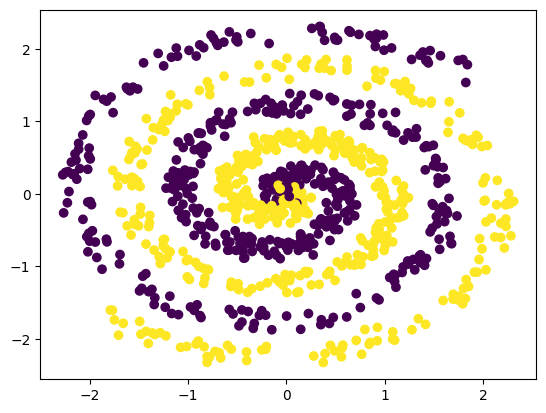

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

#### Separa Conjuntos Treino / Teste

In [4]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, to_categorical(Y), test_size=0.2, random_state=1000, shuffle=False)

#### Calcula Regressão Logistica

In [5]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(penalty='l2', C=0.01, random_state=1000)
print(np.mean(cross_val_score(lr, X, Y, cv=10)))

0.5650000000000001


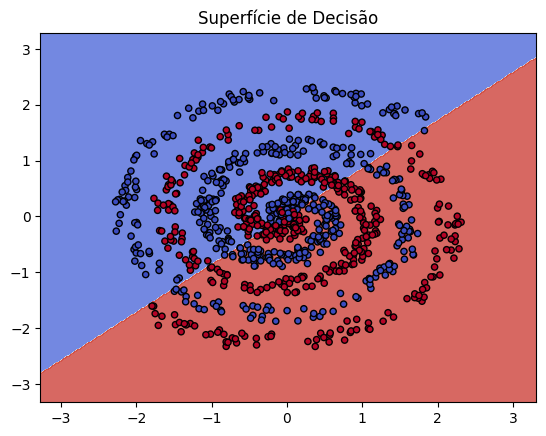

In [6]:
lr.fit(X, Y)
plot_model(lr)

#### Calcular melhores parâmetros para o SVM

In [7]:
import multiprocessing 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
 
param_grid = [
 { 
   'kernel': ['rbf', 'poly'],
   'C': [ 0.1, 0.5, 1.0, 1.5 ],
   'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
   'gamma': [0.001, 0.01, 0.1, 0.5]
 }
]

gs = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='accuracy', cv=8,  n_jobs=multiprocessing.cpu_count())

gs.fit(X,Y)
print(gs.best_estimator_.get_params())
print(gs.best_score_)

{'C': 1.5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 5, 'gamma': 0.1, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
0.5900000000000001


D:\Backup\OneDrive - puc-rio.br\Jupyter\venvs\mlclass\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


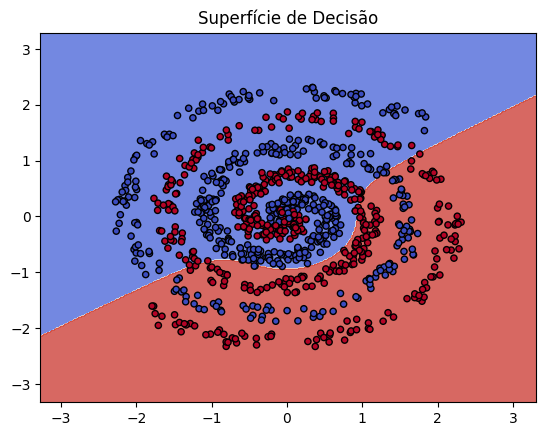

In [8]:
plot_model(gs.best_estimator_)

#### Calcular Rede MLP

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras import Input

model = Sequential()

model.add(Input(shape=(2,)))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Executa Treinamento

In [10]:
from keras.utils import to_categorical
model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size=32,
          validation_data=(X_test, Y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5367 - loss: 0.7021 - val_accuracy: 0.5600 - val_loss: 0.6772
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5442 - loss: 0.6815 - val_accuracy: 0.5700 - val_loss: 0.6724
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5488 - loss: 0.6764 - val_accuracy: 0.5750 - val_loss: 0.6701
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5711 - loss: 0.6752 - val_accuracy: 0.5650 - val_loss: 0.6657
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5622 - loss: 0.6689 - val_accuracy: 0.5600 - val_loss: 0.6650
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5646 - loss: 0.6688 - val_accuracy: 0.5400 - val_loss: 0.6652
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5561 - loss: 0.6657 - val_accuracy: 0.5300 - val_loss: 0.6634
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5513 - loss: 0.6626 - val_accuracy: 0.5350 - 

#### Realiza Predição a partir do Modelo Treinado

In [11]:
Y_eval_mlp = np.argmax(model.predict(X_test), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


#### Plota resultado do conjunto de Teste

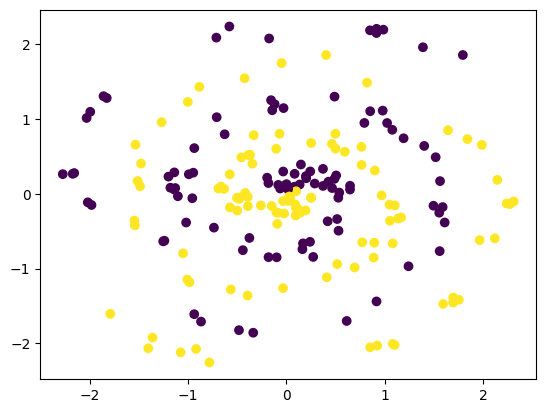

In [12]:
import matplotlib.pyplot as plt
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_eval_mlp)
plt.show()

#### Plota resultado do conjunto de Treinamento

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


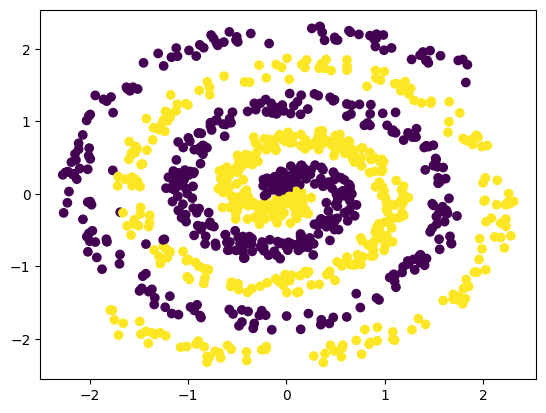

In [13]:
import matplotlib.pyplot as plt
Y_eval_mlp = np.argmax(model.predict(X), axis=1)
plt.scatter(X[:, 0], X[:, 1], c=Y_eval_mlp)
plt.show()

#### Calcula Superfície da MLP

In [14]:
import numpy as np

Xm = np.linspace(-2.0, 2.0, 1000)
Ym = np.linspace(-2.0, 2.0, 1000)
Xmg, Ymg = np.meshgrid(Xm, Ym)
X_eval = np.vstack([Xmg.ravel(), Ymg.ravel()]).T
Y_eval_mlp = np.argmax(model.predict(X_eval), axis=1)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


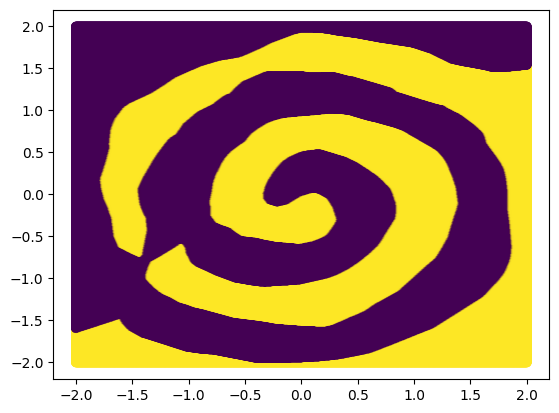

In [15]:
import matplotlib.pyplot as plt
plt.scatter(X_eval[:, 0], X_eval[:, 1], c=Y_eval_mlp)
plt.show()

#### Calcula Regressão Logística p/ Comparação

In [16]:
from sklearn.linear_model import LogisticRegression 
 
lr = LogisticRegression() 
lr.fit(X, Y)

LogisticRegression()

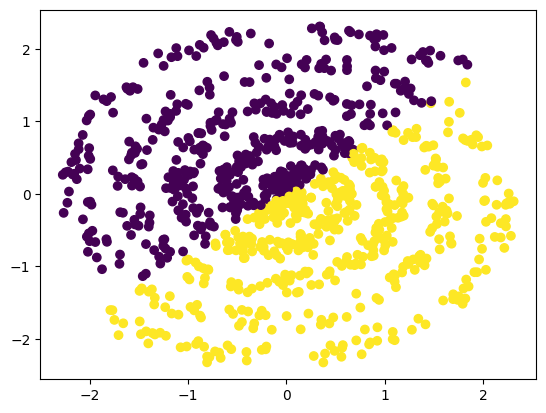

In [17]:
import matplotlib.pyplot as plt
Y_eval_lr = lr.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=Y_eval_lr)
plt.show()

In [18]:
"""
import numpy as np

Xm = np.linspace(-2.0, 2.0, 1000)
Ym = np.linspace(-2.0, 2.0, 1000)
Xmg, Ymg = np.meshgrid(Xm, Ym)
X_eval = np.vstack([Xmg.ravel(), Ymg.ravel()]).T
"""
Y_eval_lr = lr.predict(X_eval)

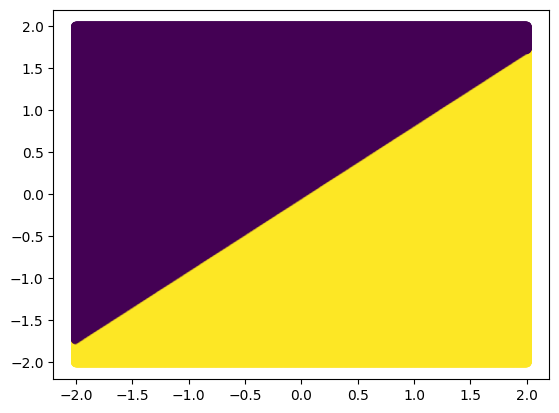

In [19]:
import matplotlib.pyplot as plt
plt.scatter(X_eval[:, 0], X_eval[:, 1], c=Y_eval_lr)
plt.show()

## Interface Keras para scikit-learn

#### Define Arquitetura da Rede

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras import Input

def build_model(lr=0.001):

 model = Sequential()
    
 model.add(Input(shape=(2,)))
 model.add(Dense(64))
 model.add(Activation('relu'))

 model.add(Dense(32))
 model.add(Activation('relu'))

 model.add(Dense(16))
 model.add(Activation('relu'))

 model.add(Dense(2))
 model.add(Activation('softmax'))

 model.compile(optimizer=Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

 return model

#### Define Função com Classificador

In [22]:
from scikeras.wrappers import KerasClassifier

skmodel = KerasClassifier(model=build_model, epochs=50, batch_size=32, lr=0.001) 

#### Procura os melhores parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical

parameters = {
 'lr': [0.001, 0.01, 0.1],
 'batch_size': [32, 64, 128]
}

gs = GridSearchCV(skmodel, parameters, cv=5)
gs.fit(X, to_categorical(Y, 2))

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5144 - loss: 0.6972
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5672 - loss: 0.6713
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5473 - loss: 0.6784 
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5785 - loss: 0.6682
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5718 - loss: 0.6725 
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5969 - loss: 0.6592
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5520 - loss: 0.6676
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5858 - loss: 0.6612
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6028 - loss: 0.6550
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5896 - loss: 0.6552 
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5829 - loss: 0.6585 
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5888 

13/13 [==============================] - 0s 2ms/step - loss: 0.6642 - accuracy: 0.5788
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.5913
Epoch 8/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0.6050
Epoch 9/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.6037
Epoch 10/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6551 - accuracy: 0.6025
Epoch 11/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6150
Epoch 12/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.6125
Epoch 13/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.6488
Epoch 14/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6500
Epoch 15/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6389 - accuracy: 0.6725
Epoch 16/100
13/

13/13 [==============================] - 0s 3ms/step - loss: 0.4494 - accuracy: 0.7050
Epoch 89/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4426 - accuracy: 0.7025
Epoch 90/100
13/13 [==============================] - 0s 4ms/step - loss: 0.4382 - accuracy: 0.7212
Epoch 91/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4336 - accuracy: 0.7138
Epoch 92/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4303 - accuracy: 0.7225
Epoch 93/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.7312
Epoch 94/100
13/13 [==============================] - 0s 2ms/step - loss: 0.4232 - accuracy: 0.7362
Epoch 95/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4192 - accuracy: 0.7437
Epoch 96/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4138 - accuracy: 0.7350
Epoch 97/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4109 - accuracy: 0.7400
Epoch 98/100


13/13 [==============================] - 0s 2ms/step - loss: 0.5265 - accuracy: 0.7250
Epoch 51/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5230 - accuracy: 0.7262
Epoch 52/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5237 - accuracy: 0.7138
Epoch 53/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.7337
Epoch 54/100
13/13 [==============================] - 0s 3ms/step - loss: 0.5138 - accuracy: 0.7200
Epoch 55/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5093 - accuracy: 0.7312
Epoch 56/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5035 - accuracy: 0.7350
Epoch 57/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5008 - accuracy: 0.7337
Epoch 58/100
13/13 [==============================] - 0s 2ms/step - loss: 0.4962 - accuracy: 0.7387
Epoch 59/100
13/13 [==============================] - 0s 2ms/step - loss: 0.4969 - accuracy: 0.7300
Epoch 60/100


13/13 [==============================] - 0s 3ms/step - loss: 0.5468 - accuracy: 0.6825
Epoch 13/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5048 - accuracy: 0.7188
Epoch 14/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5004 - accuracy: 0.6875
Epoch 15/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.7163
Epoch 16/100
13/13 [==============================] - 0s 2ms/step - loss: 0.4952 - accuracy: 0.7337
Epoch 17/100
13/13 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.7675
Epoch 18/100
13/13 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.7812
Epoch 19/100
13/13 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.8087
Epoch 20/100
13/13 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8325
Epoch 21/100
13/13 [==============================] - 0s 2ms/step - loss: 0.3388 - accuracy: 0.8363
Epoch 22/100


13/13 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9912
Epoch 95/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9812
Epoch 96/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.9638
Epoch 97/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1742 - accuracy: 0.9575
Epoch 98/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9762
Epoch 99/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0723 - accuracy: 0.9762
Epoch 100/100
4/4 [==============================] - 0s 2ms/step
Epoch 1/100
13/13 [==============================] - 1s 2ms/step - loss: 0.6871 - accuracy: 0.5450
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6633 - accuracy: 0.5913
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6541 - accuracy: 0.6012
Epoch 4/100
13/13 [==============================] 

13/13 [==============================] - 0s 4ms/step - loss: 0.0341 - accuracy: 0.9887
Epoch 57/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9837
Epoch 58/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0315 - accuracy: 0.9887
Epoch 59/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0337 - accuracy: 0.9875
Epoch 60/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0309 - accuracy: 0.9887
Epoch 61/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9900
Epoch 62/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9937
Epoch 63/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0328 - accuracy: 0.9900
Epoch 64/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0269 - accuracy: 0.9925
Epoch 65/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0340 - accuracy: 0.9900
Epoch 66/100


13/13 [==============================] - 0s 8ms/step - loss: 0.6941 - accuracy: 0.5075
Epoch 19/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.4800
Epoch 20/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.4775
Epoch 21/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5175
Epoch 22/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4925
Epoch 23/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5050
Epoch 24/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4900
Epoch 25/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5100
Epoch 26/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4975
Epoch 27/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6966 - accuracy: 0.4850
Epoch 28/100


4/4 [==============================] - 0s 3ms/step
Epoch 1/100
13/13 [==============================] - 1s 2ms/step - loss: 0.7715 - accuracy: 0.5263
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.5300
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6873 - accuracy: 0.5250
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.5575
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.5063
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6956 - accuracy: 0.5125
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5000
Epoch 8/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6952 - accuracy: 0.5025
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.4900
Epoch 10/100
13/13 [==============================] - 0s 7

13/13 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4863
Epoch 63/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.4988
Epoch 64/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.5188
Epoch 65/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.4938
Epoch 66/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.5063
Epoch 67/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6963 - accuracy: 0.5188
Epoch 68/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.4988
Epoch 69/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.4988
Epoch 70/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6967 - accuracy: 0.5063
Epoch 71/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5063
Epoch 72/100


13/13 [==============================] - 0s 2ms/step - loss: 0.5909 - accuracy: 0.6000
Epoch 25/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5705 - accuracy: 0.6087
Epoch 26/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5517 - accuracy: 0.6162
Epoch 27/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5753 - accuracy: 0.5900
Epoch 28/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6043 - accuracy: 0.6000
Epoch 29/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.6187
Epoch 30/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5687 - accuracy: 0.6275
Epoch 31/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.6325
Epoch 32/100
13/13 [==============================] - 0s 2ms/step - loss: 0.5901 - accuracy: 0.6237
Epoch 33/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6367 - accuracy: 0.5962
Epoch 34/100


7/7 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.7237
Epoch 89/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4686 - accuracy: 0.7212
Epoch 90/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4691 - accuracy: 0.7212
Epoch 91/100
7/7 [==============================] - 0s 4ms/step - loss: 0.4670 - accuracy: 0.7163
Epoch 92/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4649 - accuracy: 0.7175
Epoch 93/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.7400
Epoch 94/100
7/7 [==============================] - 0s 4ms/step - loss: 0.4623 - accuracy: 0.7475
Epoch 95/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4647 - accuracy: 0.7175
Epoch 96/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4587 - accuracy: 0.7325
Epoch 97/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4566 - accuracy: 0.7375
Epoch 98/100
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 0.5773 - accuracy: 0.7013
Epoch 55/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5737 - accuracy: 0.6988
Epoch 56/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7075
Epoch 57/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5687 - accuracy: 0.7113
Epoch 58/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5656 - accuracy: 0.7013
Epoch 59/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5610 - accuracy: 0.7063
Epoch 60/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5591 - accuracy: 0.7050
Epoch 61/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5565 - accuracy: 0.7000
Epoch 62/100
7/7 [==============================] - 0s 4ms/step - loss: 0.5539 - accuracy: 0.6800
Epoch 63/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5509 - accuracy: 0.6938
Epoch 64/100
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6562
Epoch 21/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6562
Epoch 22/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6637
Epoch 23/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6356 - accuracy: 0.6575
Epoch 24/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6346 - accuracy: 0.6612
Epoch 25/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6330 - accuracy: 0.6612
Epoch 26/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6317 - accuracy: 0.6675
Epoch 27/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6625
Epoch 28/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6625
Epoch 29/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6700
Epoch 30/100
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.0567 - accuracy: 0.9862
Epoch 87/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0811 - accuracy: 0.9775
Epoch 88/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0476 - accuracy: 0.9887
Epoch 89/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0573 - accuracy: 0.9812
Epoch 90/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.9787
Epoch 91/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0601 - accuracy: 0.9850
Epoch 92/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0567 - accuracy: 0.9787
Epoch 93/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0464 - accuracy: 0.9912
Epoch 94/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.9862
Epoch 95/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.9812
Epoch 96/100
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 0.2442 - accuracy: 0.8825
Epoch 53/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.9050
Epoch 54/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1936 - accuracy: 0.9325
Epoch 55/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.8888
Epoch 56/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2114 - accuracy: 0.9162
Epoch 57/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2068 - accuracy: 0.9463
Epoch 58/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.9450
Epoch 59/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1372 - accuracy: 0.9688
Epoch 60/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1730 - accuracy: 0.9538
Epoch 61/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1610 - accuracy: 0.9613
Epoch 62/100
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 0.5147 - accuracy: 0.6800
Epoch 19/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5119 - accuracy: 0.7237
Epoch 20/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4997 - accuracy: 0.7125
Epoch 21/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4945 - accuracy: 0.7487
Epoch 22/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4916 - accuracy: 0.7262
Epoch 23/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4702 - accuracy: 0.7038
Epoch 24/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4707 - accuracy: 0.7538
Epoch 25/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4738 - accuracy: 0.7337
Epoch 26/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4625 - accuracy: 0.7500
Epoch 27/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4748 - accuracy: 0.7450
Epoch 28/100
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.5412
Epoch 85/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6836 - accuracy: 0.5425
Epoch 86/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.4925
Epoch 87/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5300
Epoch 88/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.5325
Epoch 89/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5113
Epoch 90/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6836 - accuracy: 0.5412
Epoch 91/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6809 - accuracy: 0.5537
Epoch 92/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5075
Epoch 93/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5562
Epoch 94/100
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5188
Epoch 51/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5188
Epoch 52/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5188
Epoch 53/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5188
Epoch 54/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5188
Epoch 55/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5063
Epoch 56/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4988
Epoch 57/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.5188
Epoch 58/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4863
Epoch 59/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.4888
Epoch 60/100
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.5962
Epoch 17/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5914 - accuracy: 0.6062
Epoch 18/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5801 - accuracy: 0.6363
Epoch 19/100
7/7 [==============================] - 0s 4ms/step - loss: 0.5953 - accuracy: 0.6562
Epoch 20/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5616 - accuracy: 0.6575
Epoch 21/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5815 - accuracy: 0.6837
Epoch 22/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5721 - accuracy: 0.6662
Epoch 23/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5630 - accuracy: 0.6700
Epoch 24/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5473 - accuracy: 0.6325
Epoch 25/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5331 - accuracy: 0.6775
Epoch 26/100
7/7 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0488 - accuracy: 0.9830
Epoch 83/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0363 - accuracy: 0.9880
Epoch 84/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0481 - accuracy: 0.9880
Epoch 85/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0408 - accuracy: 0.9840
Epoch 86/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0439 - accuracy: 0.9820
Epoch 87/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0403 - accuracy: 0.9850
Epoch 88/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9860
Epoch 89/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 0.9900
Epoch 90/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0315 - accuracy: 0.9890
Epoch 91/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9900
Epoch 92/100
8/8 [===============

GridSearchCV(cv=5,
             estimator=KerasClassifier(batch_size=32, epochs=100, lr=0.001, model=<function build_model at 0x000002C19494B948>),
             param_grid={'batch_size': [32, 64, 128], 'lr': [0.001, 0.01, 0.1]})

#### Exibe melhores parâmetros encontrados

In [26]:
print(gs.best_score_)
print(gs.best_params_)

0.9780000000000001
{'batch_size': 64, 'lr': 0.01}


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


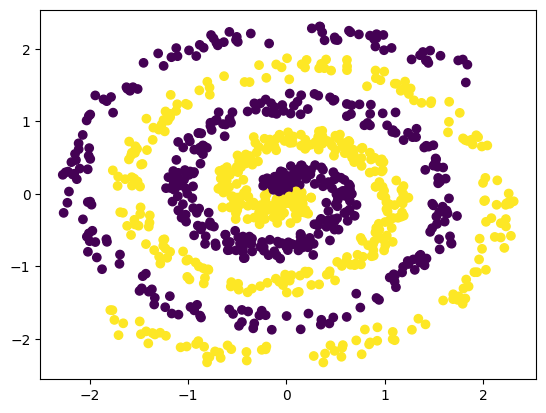

In [27]:
import matplotlib.pyplot as plt

Y_eval_mlp = np.argmax(gs.best_estimator_.predict(X), axis=1)
plt.scatter(X[:, 0], X[:, 1], c=Y_eval_mlp)
plt.show()

In [29]:
import numpy as np
"""
Xm = np.linspace(-2.0, 2.0, 1000)
Ym = np.linspace(-2.0, 2.0, 1000)
Xmg, Ymg = np.meshgrid(Xm, Ym)
X_eval = np.vstack([Xmg.ravel(), Ymg.ravel()]).T
X_eval = np.float32(X_eval)
"""
Y_eval_mlp = np.argmax(gs.best_estimator_.predict(np.float32(X_eval)), axis=1)

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step


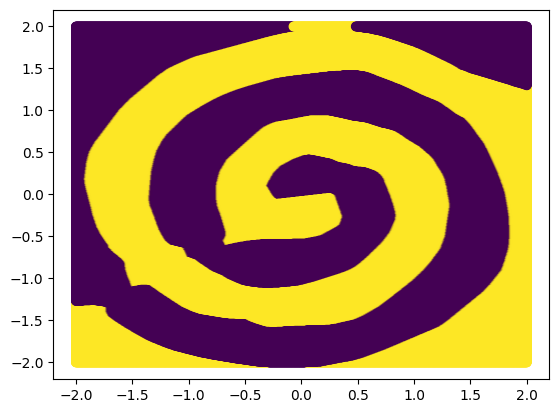

In [30]:
import matplotlib.pyplot as plt
plt.scatter(X_eval[:, 0], X_eval[:, 1], c=Y_eval_mlp)
plt.show()

## Algoritmos de Treinamento

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras import Input

def build_model_alg_example():
    
    model = Sequential()
   
    model.add(Input(shape=(2,)))
    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(32))
    model.add(Activation('relu'))

    model.add(Dense(16))
    model.add(Activation('relu'))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    return model

### Stochastic Gradient Descendent

In [34]:
from keras.optimizers import SGD

sgd_model = build_model_alg_example()

#SGD com momentum
sgd = SGD(learning_rate=0.01, decay = 0.001, momentum=0.99, nesterov=True)

sgd_model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
sgd_model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size=32,
          validation_data=(X_test, Y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5244 - loss: 0.6849 - val_accuracy: 0.6200 - val_loss: 0.6726
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5768 - loss: 0.6734 - val_accuracy: 0.5550 - val_loss: 0.6682
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5242 - loss: 0.6811 - val_accuracy: 0.5950 - val_loss: 0.6567
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6353 - loss: 0.6695 - val_accuracy: 0.5100 - val_loss: 0.6595
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5960 - loss: 0.6672 - val_accuracy: 0.5550 - val_loss: 0.6611
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.6640 - val_accuracy: 0.6400 - val_loss: 0.6430
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6090 - loss: 0.6542 - val_accuracy: 0.5800 - val_loss: 0.6494
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6478 - loss: 0.6454 - val_accuracy: 0.6050 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


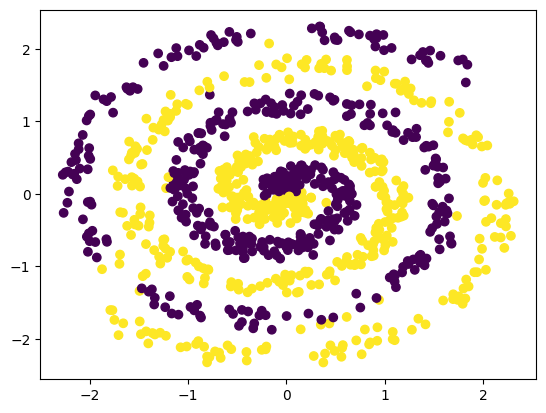

In [36]:
plot_scatter_model(sgd_model)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step


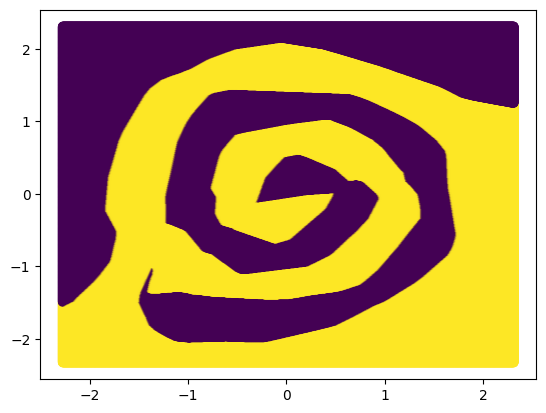

In [37]:
plot_surface_model(sgd_model)

### RMSProp

In [38]:
from keras.optimizers import RMSprop

rms_prop_model = build_model_alg_example()

rms_prop = RMSprop(learning_rate =0.01, rho=0.99, epsilon=1e-6, decay=1e-3)

rms_prop_model.compile(optimizer=rms_prop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [39]:
rms_prop_model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size=32,
          validation_data=(X_test, Y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5118 - loss: 0.7145 - val_accuracy: 0.5350 - val_loss: 0.6770
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5375 - loss: 0.6800 - val_accuracy: 0.5500 - val_loss: 0.6686
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5859 - loss: 0.6701 - val_accuracy: 0.5600 - val_loss: 0.6604
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5713 - loss: 0.6682 - val_accuracy: 0.5450 - val_loss: 0.6511
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5937 - loss: 0.6522 - val_accuracy: 0.6200 - val_loss: 0.6548
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5876 - loss: 0.6694 - val_accuracy: 0.6250 - val_loss: 0.6554
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6120 - loss: 0.6685 - val_accuracy: 0.6150 - val_loss: 0.6512
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6214 - loss: 0.6733 - val_accuracy: 0.5750 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


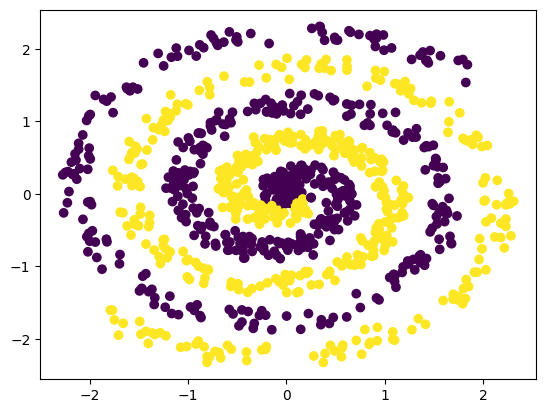

In [40]:
plot_scatter_model(rms_prop_model)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step


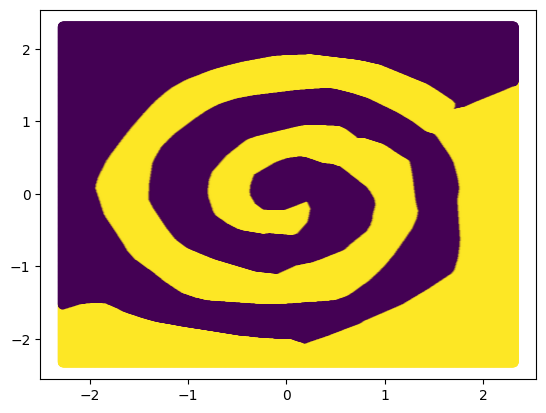

In [41]:
plot_surface_model(rms_prop_model)

### Adam

In [42]:
from keras.optimizers import Adam

adam_model = build_model_alg_example()

adam = Adam(learning_rate =0.01, beta_1=0.99, beta_2=0.99, epsilon=1e-6, decay=1e-3)

adam_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [43]:
adam_model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size=32,
          validation_data=(X_test, Y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4944 - loss: 0.6953 - val_accuracy: 0.5050 - val_loss: 0.6667
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5619 - loss: 0.6630 - val_accuracy: 0.5250 - val_loss: 0.6748
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5599 - loss: 0.6707 - val_accuracy: 0.5150 - val_loss: 0.6790
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5732 - loss: 0.6716 - val_accuracy: 0.5150 - val_loss: 0.6699
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5728 - loss: 0.6762 - val_accuracy: 0.5500 - val_loss: 0.6612
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6105 - loss: 0.6599 - val_accuracy: 0.5700 - val_loss: 0.6620
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6153 - loss: 0.6573 - val_accuracy: 0.5500 - val_loss: 0.6620
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5942 - loss: 0.6622 - val_accuracy: 0.5700 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


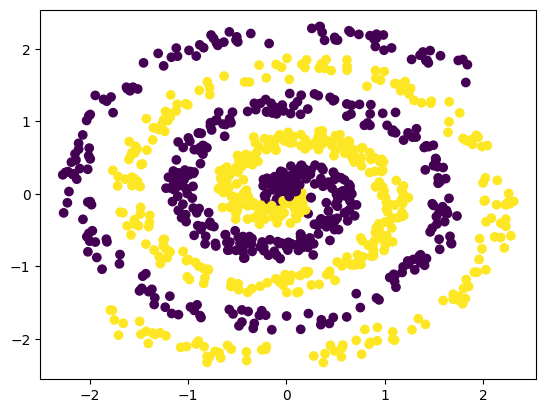

In [44]:
plot_scatter_model(adam_model)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step


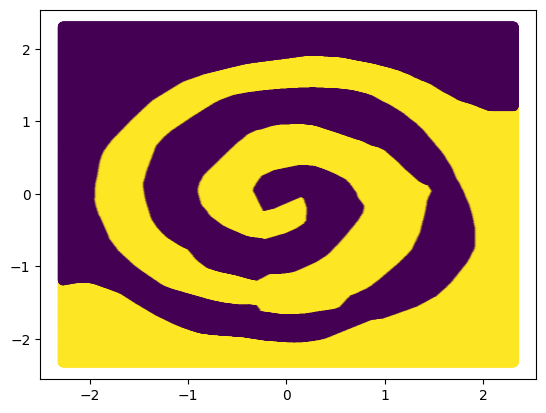

In [45]:
plot_surface_model(adam_model)

### AdaGrad

In [46]:
from keras.optimizers import Adagrad

adagrad_model = build_model_alg_example()

adagrad = Adagrad(learning_rate =0.01, epsilon=1e-6, decay=1e-3)

adagrad_model.compile(optimizer=adagrad,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [47]:
adagrad_model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size=32,
          validation_data=(X_test, Y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4869 - loss: 0.7088 - val_accuracy: 0.4700 - val_loss: 0.6957
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5387 - loss: 0.6891 - val_accuracy: 0.4900 - val_loss: 0.6908
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5633 - loss: 0.6787 - val_accuracy: 0.5000 - val_loss: 0.6885
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5720 - loss: 0.6786 - val_accuracy: 0.5100 - val_loss: 0.6861
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5670 - loss: 0.6746 - val_accuracy: 0.5100 - val_loss: 0.6821
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5371 - loss: 0.6739 - val_accuracy: 0.5250 - val_loss: 0.6816
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5701 - loss: 0.6697 - val_accuracy: 0.5100 - val_loss: 0.6788
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5351 - loss: 0.6755 - val_accuracy: 0.4950 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


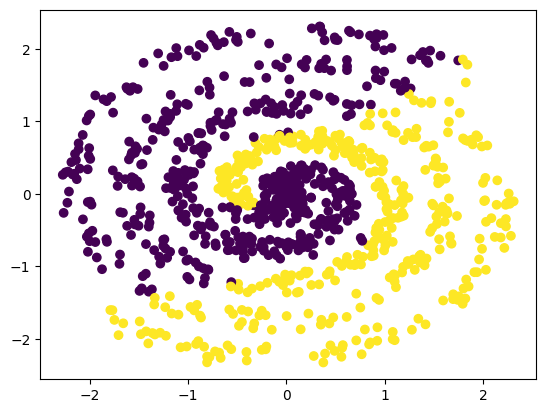

In [48]:
plot_scatter_model(adagrad_model)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step


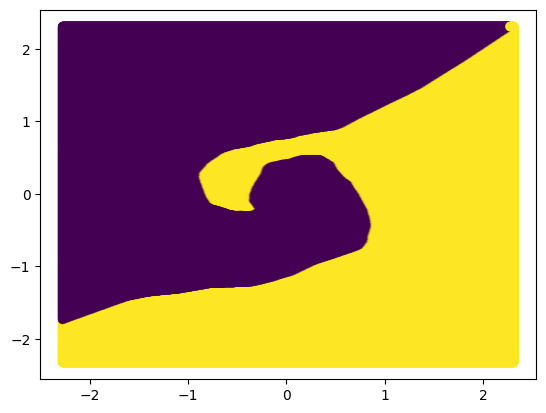

In [49]:
plot_surface_model(adagrad_model)

## AdaDelta

In [52]:
from keras.optimizers import Adadelta

adadelta_model = build_model_alg_example()

adadelta = Adadelta(learning_rate=0.01, rho=0.99, epsilon=1e-6, decay=1e-6)

adadelta_model.compile(optimizer=adadelta,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [53]:
adadelta_model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size=32,
          validation_data=(X_test, Y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4822 - loss: 0.6930 - val_accuracy: 0.5500 - val_loss: 0.6908
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4757 - loss: 0.6934 - val_accuracy: 0.5250 - val_loss: 0.6893
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4958 - loss: 0.6942 - val_accuracy: 0.5250 - val_loss: 0.6880
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5340 - loss: 0.6873 - val_accuracy: 0.5100 - val_loss: 0.6870
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5199 - loss: 0.6894 - val_accuracy: 0.5100 - val_loss: 0.6861
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5417 - loss: 0.6882 - val_accuracy: 0.5200 - val_loss: 0.6853
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5371 - loss: 0.6850 - val_accuracy: 0.5100 - val_loss: 0.6845
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5644 - loss: 0.6816 - val_accuracy: 0.5100 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


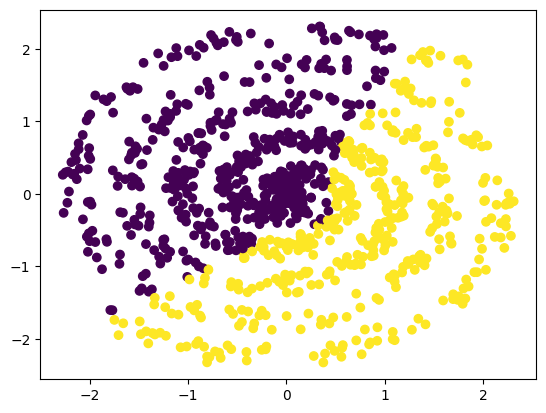

In [54]:
plot_scatter_model(adadelta_model)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step


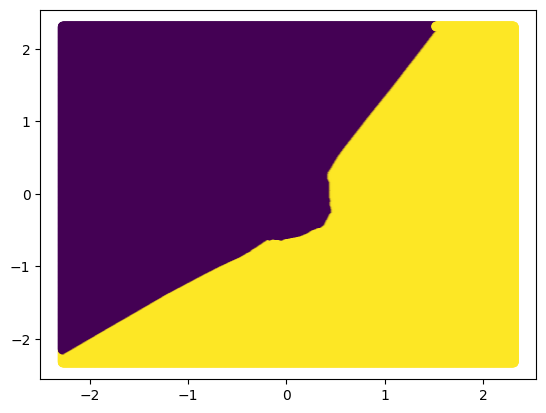

In [55]:
plot_surface_model(adadelta_model)

## Autotune

#### Define arquitetura da Rede

In [57]:
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer
from keras.optimizers import SGD, Adam
from keras import Input

def build_model(n_hidden=2, n_neurons=64, learning_rate=3e-3, input_shape=[2]):
    model = Sequential()
   
    model.add(Input(shape=(2,)))
    #model.add(InputLayer(input_shape=input_shape))
    model.add(Dense(n_neurons))
    model.add(Activation('relu'))
    
    for layer in range(n_hidden):
        model.add(Dense(n_neurons))
        #model.add(Dense(n_neurons/(2**(layer+1))))
        model.add(Activation('relu'))
    
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    #optimizer = SGD(learning_rate=learning_rate)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  #loss='mse',
              metrics=['accuracy'])
    
    return model

#keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
keras_class = KerasClassifier(model=build_model, epochs=100, batch_size=32,
                              n_hidden=2, n_neurons=64, learning_rate=0.01)


keras_class.fit(X_train, Y_train, 
              epochs=100, 
              batch_size=32,
              validation_data=(X_test, Y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4901 - loss: 0.7013 - val_accuracy: 0.6150 - val_loss: 0.6715
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5753 - loss: 0.6673 - val_accuracy: 0.5600 - val_loss: 0.6668
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5488 - loss: 0.6741 - val_accuracy: 0.5650 - val_loss: 0.6583
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5784 - loss: 0.6727 - val_accuracy: 0.5650 - val_loss: 0.6515
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5708 - loss: 0.6732 - val_accuracy: 0.6150 - val_loss: 0.6544
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6190 - loss: 0.6582 - val_accuracy: 0.6200 - val_loss: 0.6725
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6204 - loss: 0.6746 - val_accuracy: 0.6750 - val_loss: 0.6440
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6616 - loss: 0.6508 - val_accuracy: 0.6400 - 

KerasClassifier(
	model=<function build_model at 0x000001FCDF3164D0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	n_hidden=2
	n_neurons=64
	learning_rate=0.01
	class_weight=None
)

#### Encontra os melhores parâmetros

In [58]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import multiprocessing 

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": [0.01,0.001,0.0001]
}


'''
gs = GridSearchCV(estimator=keras_class, param_grid=param_distribs, scoring='accuracy', cv=8,  n_jobs=multiprocessing.cpu_count())
gs.fit(X_train, Y_train, epochs=100,
                  validation_data=(X_test, Y_test),
                  callbacks=[EarlyStopping(patience=10)])
'''
rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3,n_jobs=multiprocessing.cpu_count())
rnd_search_cv.fit(X_train, Y_train, epochs=50,
                  validation_data=(X_test, Y_test),
                  callbacks=[EarlyStopping(patience=10)])
                  

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5181 - loss: 0.6882 - val_accuracy: 0.5150 - val_loss: 0.6740
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5720 - loss: 0.6736 - val_accuracy: 0.4850 - val_loss: 0.6775
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5650 - loss: 0.6691 - val_accuracy: 0.4950 - val_loss: 0.6708
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5414 - loss: 0.6756 - val_accuracy: 0.4750 - val_loss: 0.6699
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5705 - loss: 0.6608 - val_accuracy: 0.5700 - val_loss: 0.6664
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6168 - loss: 0.6628 - val_accuracy: 0.6100 - val_loss: 0.6629
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6406 - loss: 0.6567 - val_accuracy: 0.6650 - val_loss: 0.6470
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6684 - loss: 0.6492 - val_accuracy: 0.7050 - val_loss

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, epochs=100, learning_rate=0.01, model=<function build_model at 0x000001FCDF3164D0>, n_hidden=2, n_neurons=64),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.01, 0.001, 0.0001],
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

#### Apresenta melhores parâmetros

In [59]:
model = rnd_search_cv.best_estimator_
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
    
#mse_test = keras_class.score(X_test, y_test)
#y_pred = keras_reg.predict(X_new)

{'n_neurons': 71, 'n_hidden': 3, 'learning_rate': 0.001}
0.9575155116255057


#### Calcula Resultado de Predição

In [60]:
Y_eval_mlp = np.argmax(model.predict(X), axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


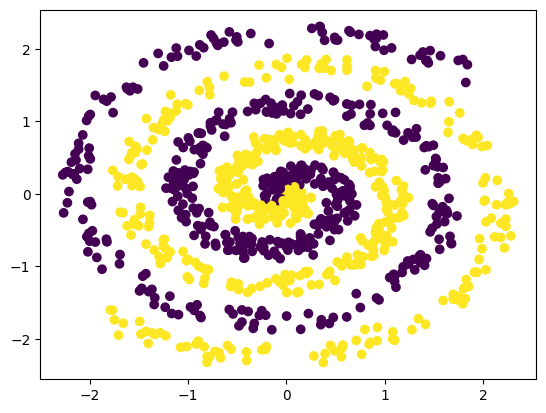

In [61]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=Y_eval_mlp)
plt.show()

#### Plota Superfície de Decisão

In [62]:
import numpy as np

Xm = np.linspace(min(X[:, 0]), max(X[:, 0]), 1000)
Ym = np.linspace(min(X[:, 1]), max(X[:, 1]), 1000)
Xmg, Ymg = np.meshgrid(Xm, Ym)
X_eval = np.vstack([Xmg.ravel(), Ymg.ravel()]).T
X_eval = np.float32(X_eval)
Y_eval_mlp = np.argmax(model.predict(X_eval), axis=1)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


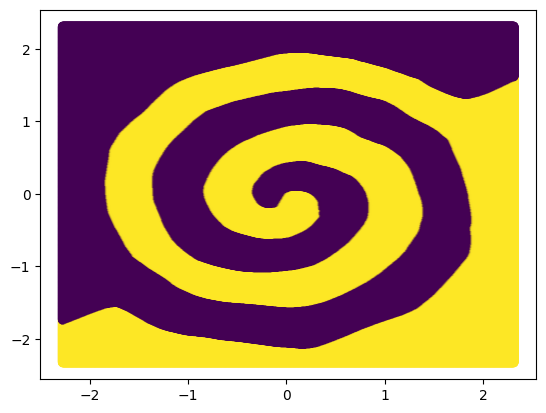

In [63]:
import matplotlib.pyplot as plt
plt.scatter(X_eval[:, 0], X_eval[:, 1], c=Y_eval_mlp)
plt.show()